In [1]:
import os
import datetime
import numpy as np
import pandas as pd
from time import time
from scipy.stats import randint as sp_randint
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ts = joblib.load('../../bld/out/data_processed/BTC_POT.p.lzma')

In [3]:
# Restriction to chart data only
ts = ts[ts.CHART == True].dropna(axis=1).drop(['CHART', 'TRADE'], axis=1)

# Support Vector Regression

## Links
- [sklearn description of SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
- [A Tutorial on Support Vector Regression](https://alex.smola.org/papers/2003/SmoSch03b.pdf)
- [Problem concerning SVR predicting constant values because y is small, adjust with small epsilon](http://stackoverflow.com/questions/24944646/scikit-svm-regression-predicts-constant-result)

# Run RandomGridSearch

In [4]:
# Adjust variables
y = ts.BTC_POT_CLOSE
X = ts.drop('BTC_POT_CLOSE', axis=1)
X = StandardScaler().fit_transform(X)

# build a classifier
clf = svm.SVR()

# Cross validator
tscv = TimeSeriesSplit(n_splits=3)

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {
    'C': np.arange(0.7, 1.05, 0.1),
    'epsilon': [1e-10, 1e-12, 1e-14],
    'kernel': ['rbf'],
    'tol': [1e-10, 1e-12, 1e-14],
    'max_iter': [10000],
}

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(
    clf, param_distributions=param_dist, cv=tscv, n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

C:\Anaconda3\envs\crypto\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\envs\crypto\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\envs\crypto\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\envs\crypto\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Anaconda3\envs\crypto\lib\site-pa

RandomizedSearchCV took 3127.09 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: -18.397 (std: 7.546)
Parameters: {'tol': 1e-10, 'epsilon': 1e-10, 'max_iter': 10000, 'C': 0.69999999999999996, 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: -54.454 (std: 41.794)
Parameters: {'tol': 1e-14, 'epsilon': 1e-10, 'max_iter': 10000, 'C': 0.79999999999999993, 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: -54.454 (std: 41.794)
Parameters: {'tol': 1e-10, 'epsilon': 1e-10, 'max_iter': 10000, 'C': 0.79999999999999993, 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: -54.454 (std: 41.794)
Parameters: {'tol': 1e-12, 'epsilon': 1e-10, 'max_iter': 10000, 'C': 0.79999999999999993, 'kernel': 'rbf'}



C:\Anaconda3\envs\crypto\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


# Run prediction

In [5]:
X_train = ts.loc['2014':'2015'].drop('BTC_POT_CLOSE', axis=1)
X_train = StandardScaler().fit_transform(X_train)
y_train = ts.loc['2014':'2015', 'BTC_POT_CLOSE']

X_test = ts.loc['2016':'2017'].drop('BTC_POT_CLOSE', axis=1)
X_test = StandardScaler().fit_transform(X_test)
y_test = ts.loc['2016':'2017', 'BTC_POT_CLOSE']

# specify parameters and distributions to sample from
param_dist = {
    'C': 0.7,
    'epsilon': 1e-10,
    'kernel': 'rbf',
    'tol': 1e-10,
    'max_iter': 20000
}

# build a classifier
clf = svm.SVR(**param_dist)

# Cross validator
# tscv = TimeSeriesSplit(n_splits=3)

# fit
clf = clf.fit(X_train, y_train)
ts.loc['2016' : '2017', 'BTC_POT_CLOSE_PREDICTION'] = clf.predict(X_test)

C:\Anaconda3\envs\crypto\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


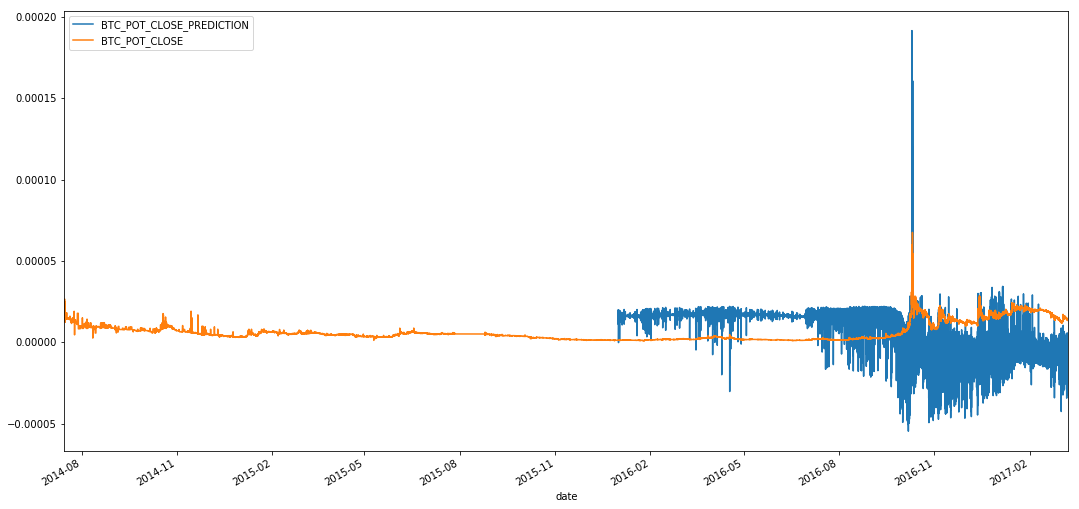

In [6]:
ts[['BTC_POT_CLOSE_PREDICTION', 'BTC_POT_CLOSE']].plot(figsize=(18, 9))

In [7]:
ts.drop('BTC_POT_CLOSE_PREDICTION', axis=1, inplace=True)